In [1]:
from helper import *
from word_embeddings import *
from gensim.models import Word2Vec
import numpy as np
import pandas as pd
from functools import reduce
import gensim
from word_embeddings import *
from sklearn.manifold import TSNE
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

1. Load dataframe with preprocessed data

In [2]:
df = pd.read_csv("saved_dataframes/preprocessed_df.csv")
df = df.rename({"content": "0", "preprocessed": "content"}, axis=1)
df = df.dropna()
df.head()

,0,day,index,month,content,transcriptionName,year
0,hier ist das erste deutsche Fernsehen mit der ...,1,0.0,4,deutsch_fernsehen_tagesschau_gut abend_dame_he...,transcriptions/tagesschau_01042007_2000_.txt,2007
1,hier ist das erste deutsche Fernsehen mit der ...,2,1.0,4,deutsch_fernsehen_tagesschau abend_dame_herr j...,transcriptions/tagesschau_02042007_2000_.txt,2007
2,hier ist das erste deutsche Fernsehen mit der ...,3,2.0,4,deutsch_fernsehen_tagesschau_gut abend_dame_he...,transcriptions/tagesschau_03042007_2000_.txt,2007
3,hier ist das erste deutsche Fernsehen mit der ...,4,3.0,4,deutsch_fernsehen_tagesschau_gut abend_dame_he...,transcriptions/tagesschau_04042007_2000_.txt,2007
4,hier ist das erste deutsche Fernsehen mit der ...,5,4.0,4,deutsch_fernsehen_tagesschau dame_herr iran fe...,transcriptions/tagesschau_05042007_2000_.txt,2007


2. Load our trained models for the years 2007 to 2020 and the models that cover 4-year periods (2008-2011, 2012-2015, 2016-2019)

In [3]:
yearly_models = []
for year in range(2007, 2021):
    yearly_models.append(Word2Vec.load("w2v_models/w2v_{}_new.model".format(year)))

In [4]:
models_four_years = []
for string_pair in [("08", "11"), ("12", "15"), ("16", "19")]:
    models_four_years.append(
        Word2Vec.load("w2v_models/w2v_{}-{}.model".format(string_pair[0], string_pair[1]))
    )

3. Align models

In [5]:
for m in yearly_models:
    m.init_sims()
aligned_yearly = align_gensim_models(yearly_models)
for i, year in enumerate(range(2007, 2021)):
    Word2Vec.save(aligned_yearly[i], "w2v_models/w2v_{}_aligned.model".format(year))
    
for m in models_four_years:
    m.init_sims()
aligned_fouryear = align_gensim_models(models_four_years)
for i, string_pair in enumerate([("08", "11"), ("12", "15"), ("16", "19")]):
    Word2Vec.save(aligned_fouryear[i],
                  "w2v_models/w2v_{}-{}_aligned.model".format(string_pair[0],
                                                              string_pair[1]))

4. Look at the highest and lowest change in tokens (average, pair of years, 2008->2019)

In [6]:
from sklearn.metrics.pairwise import cosine_similarity
def cosine_sim_between_models(m1, m2):
    sim_dict = {}
    for word in m1.wv.vocab:
        sim = cosine_similarity(m1[word].reshape(1, -1), m2[word].reshape(1, -1))[0,0]
        sim_dict[word] = sim
    return sim_dict

In [7]:
def cosine_similarity_adjacent_models(models, model_labels):
    sim_dict = {}
    for word in models[0].wv.vocab:
        for i in range(len(models)-1):
            m1 = models[i]
            m2 = models[i+1]
            prog = "{}->{}".format(model_labels[i], model_labels[i+1])
            sim = cosine_similarity(m1[word].reshape(1, -1), m2[word].reshape(1, -1))[0,0]
            sim_dict[(word, prog)] = sim
    return sim_dict

4.1. Yearly models:

In [8]:
print("Top/Bottom similarity from 2008 to 2019:\n")
sim_dict = cosine_sim_between_models(yearly_models[1], yearly_models[-2])
print(dict(sorted(sim_dict.items(), key=lambda item: item[1], reverse=False)[:20]))
print("\n")
print(dict(sorted(sim_dict.items(), key=lambda item: item[1], reverse=True)[:20]))

Top/Bottom similarity from 2008 to 2019:

{'großbritannien': 0.0588896, 'brite': 0.09684072, 'einschätzung': 0.10079155, 'london': 0.109422125, 'ansicht': 0.11537741, 'gipfel': 0.1250952, 'phase': 0.13053358, 'britisch': 0.1459837, 'runter': 0.14639175, 'manager': 0.15298694, 'amerika': 0.15642758, 'erfahren': 0.1620568, 'spannen': 0.1633014, 'verfügen': 0.17507039, 'aussehen': 0.17809789, 'begrüßen': 0.17816055, 'aktiv': 0.18103099, 'irland': 0.18614641, 'ziemlich': 0.18804179, 'erleichterung': 0.18821782}


{'kölner': 0.6754256, 'mönchengladbach': 0.673797, 'köln': 0.66956496, 'leverkusen': 0.667018, 'fußball': 0.66255856, 'wolfsburg': 0.66198564, 'besiegen': 0.6584372, 'fußballbundesliga': 0.65416855, 'dortmund': 0.6537609, 'spieltag': 0.65359, 'verletzen': 0.6534611, 'frankfurt': 0.6524369, 'bayer_münchen': 0.6502532, 'nordosten': 0.64693195, 'spielen': 0.64645845, 'haus': 0.64581114, 'schalke': 0.6456185, 'bundesliga': 0.645528, 'temperatur': 0.6452221, 'regenwolken': 0.6449222}


In [9]:
from collections import defaultdict

print("Average similarity for each adjacent year:")
sim_dict = cosine_similarity_adjacent_models(yearly_models,
                                             [str(x) for x in range(2007, 2021)])
sim_dict_avg = defaultdict(lambda: 0)
for key, value in sim_dict.items():
    sim_dict_avg[key[0]] += value
sorted(sim_dict_avg.items(), key=lambda item: item[1], reverse=False)[:20]

Average similarity for each adjacent year:


[('urlaub', 4.689350426197052),
 ('brechen', 4.808852031826973),
 ('danke', 4.873226344585419),
 ('gegensatz', 5.030111268162727),
 ('nahezu', 5.075589939951897),
 ('heraus', 5.084275931119919),
 ('aktiv', 5.104119420051575),
 ('kennen', 5.109851032495499),
 ('kümmern', 5.155152678489685),
 ('vorbild', 5.166598632931709),
 ('steuern', 5.210558265447617),
 ('airbus', 5.221400037407875),
 ('blockieren', 5.233037695288658),
 ('tür', 5.236899346113205),
 ('peking', 5.2469887509942055),
 ('einstellen', 5.247612357139587),
 ('hinzu', 5.259633243083954),
 ('fahrt', 5.268234133720398),
 ('gang', 5.270294278860092),
 ('gesamt', 5.288211464881897)]

In [10]:
year_sim_dict = defaultdict(lambda: {})
for pair, sim in sim_dict.items():
    year_sim_dict[pair[1]][pair[0]] = sim
for years, sim_vals in year_sim_dict.items():
    print(years)
    print("5 Biggest Differences: {}".format(dict(sorted(sim_vals.items(), key=lambda item: item[1], reverse=False)[:5])))

2007->2008
5 Biggest Differences: {'energie': 0.08655533, 'arzt': 0.111171134, 'konkurrent': 0.15232335, 'lieben': 0.16532332, 'kreis': 0.19907059}
2008->2009
5 Biggest Differences: {'airbus': 0.19715708, 'heraus': 0.26650068, 'vorbild': 0.2671952, 'liste': 0.28671944, 'blockieren': 0.29135653}
2009->2010
5 Biggest Differences: {'griechenland': 0.0016107254, 'ukraine': 0.06521618, 'athen': 0.072114155, 'spalten': 0.07629977, 'vorbild': 0.08629288}
2010->2011
5 Biggest Differences: {'geltend': 0.119409055, 'handy': 0.13807592, 'lied': 0.14881802, 'greifen': 0.16849743, 'schwarz': 0.17289118}
2011->2012
5 Biggest Differences: {'informieren': 0.059180696, 'geltend': 0.06350393, 'allgemein': 0.14370044, 'satz': 0.15471943, 'streik': 0.15543891}
2012->2013
5 Biggest Differences: {'gang': 0.13893342, 'kapitän': 0.1838824, 'gegensatz': 0.19486196, 'chinesische': 0.20528387, 'verantwortliche': 0.20585494}
2013->2014
5 Biggest Differences: {'suche': 0.18656726, 'tür': 0.19223942, 'brechen': 0.1

4.2. Four year models

In [11]:
print("Top/Bottom similarity from 2008-2011 to 2016-2019:\n")
sim_dict = cosine_sim_between_models(models_four_years[0], models_four_years[2])
print(dict(sorted(sim_dict.items(), key=lambda item: item[1], reverse=False)[:30]))
print("\n")
print(dict(sorted(sim_dict.items(), key=lambda item: item[1], reverse=True)[:30]))

Top/Bottom similarity from 2008-2011 to 2016-2019:

{'busch': -0.1811996, 'tabu': -0.16872062, 'bewerbung': -0.12886922, 'tiefpunkt': -0.08210666, 'nunmehr': -0.07543675, 'wein': -0.07085034, 'meiden': -0.06981762, 'stattdessen': -0.06655815, 'camp': -0.06527813, 'heidelberg': -0.05606607, 'unstimmigkeit': -0.054636333, 'monatelangen': -0.053737868, 'vorausgehen': -0.053375106, 'umkehren': -0.050332382, 'bratislava': -0.04745622, 'kopenhagen': -0.044071667, 'bring': -0.041925058, 'nebeneinander': -0.041473854, 'vermelden': -0.035200115, 'ungelöst': -0.033712737, 'shop': -0.031350203, 'zurückführen': -0.02968984, 'havel': -0.023338264, 'praktizieren': -0.02238177, 'wochenlang': -0.018420605, 'morgig': -0.017767914, 'g': -0.012889842, 'anstoß': -0.010906817, 'maus': -0.008582088, 'engel': -0.008378658}


{'teils_klaren': 0.7360668, 'wolkenverhangen': 0.7234186, 'räumung': 0.7228989, 'nieseln': 0.71590066, 'nebensonne': 0.7157938, 'ausstand': 0.71442974, 'nieselregen': 0.7074786, 'teils_f

In [12]:
print("Average similarity for each adjacent year:")
sim_dict = cosine_similarity_adjacent_models(models_four_years,
                                             ["08-11", "12-15", "16-19"])
sim_dict_avg = defaultdict(lambda: 0)
for key, value in sim_dict.items():
    sim_dict_avg[key[0]] += value
sorted(sim_dict_avg.items(), key=lambda item: item[1], reverse=False)[:20]

Average similarity for each adjacent year:


[('back', -0.12113434076309204),
 ('hallo', -0.002355635166168213),
 ('kater', 0.0037091225385665894),
 ('schein', 0.011993791908025742),
 ('re', 0.01846577227115631),
 ('haben', 0.029291309416294098),
 ('kein', 0.03313063737004995),
 ('totale', 0.05409472086466849),
 ('uhrzeit', 0.06460002064704895),
 ('abrechnung', 0.09638528525829315),
 ('hierbei', 0.10140526294708252),
 ('brauch', 0.10510393977165222),
 ('nett', 0.105356864631176),
 ('zeig', 0.10844535753130913),
 ('einschließlich', 0.11375140771269798),
 ('anfang_jahr', 0.12077982840128243),
 ('mathe', 0.12156618759036064),
 ('mach', 0.12390363309532404),
 ('zurückhaltend', 0.1314684022217989),
 ('stell', 0.13592589925974607)]

In [13]:
year_sim_dict = defaultdict(lambda: {})
for pair, sim in sim_dict.items():
    year_sim_dict[pair[1]][pair[0]] = sim
for years, sim_vals in year_sim_dict.items():
    print(years)
    print("5 Biggest Differences: {}".format(dict(sorted(sim_vals.items(), key=lambda item: item[1], reverse=False)[:5])))

08-11->12-15
5 Biggest Differences: {'back': -0.19005334, 'uhrzeit': -0.14801843, 'hallo': -0.09426976, 'nett': -0.06700652, 'tattoo': -0.06361092}
12-15->16-19
5 Biggest Differences: {'engel': -0.089103684, 'torte': -0.08755018, 're': -0.06916943, 'schonen': -0.06743715, 'haben': -0.056612775}


5. Plot progression of word vectors

5.1 Yearly models

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches

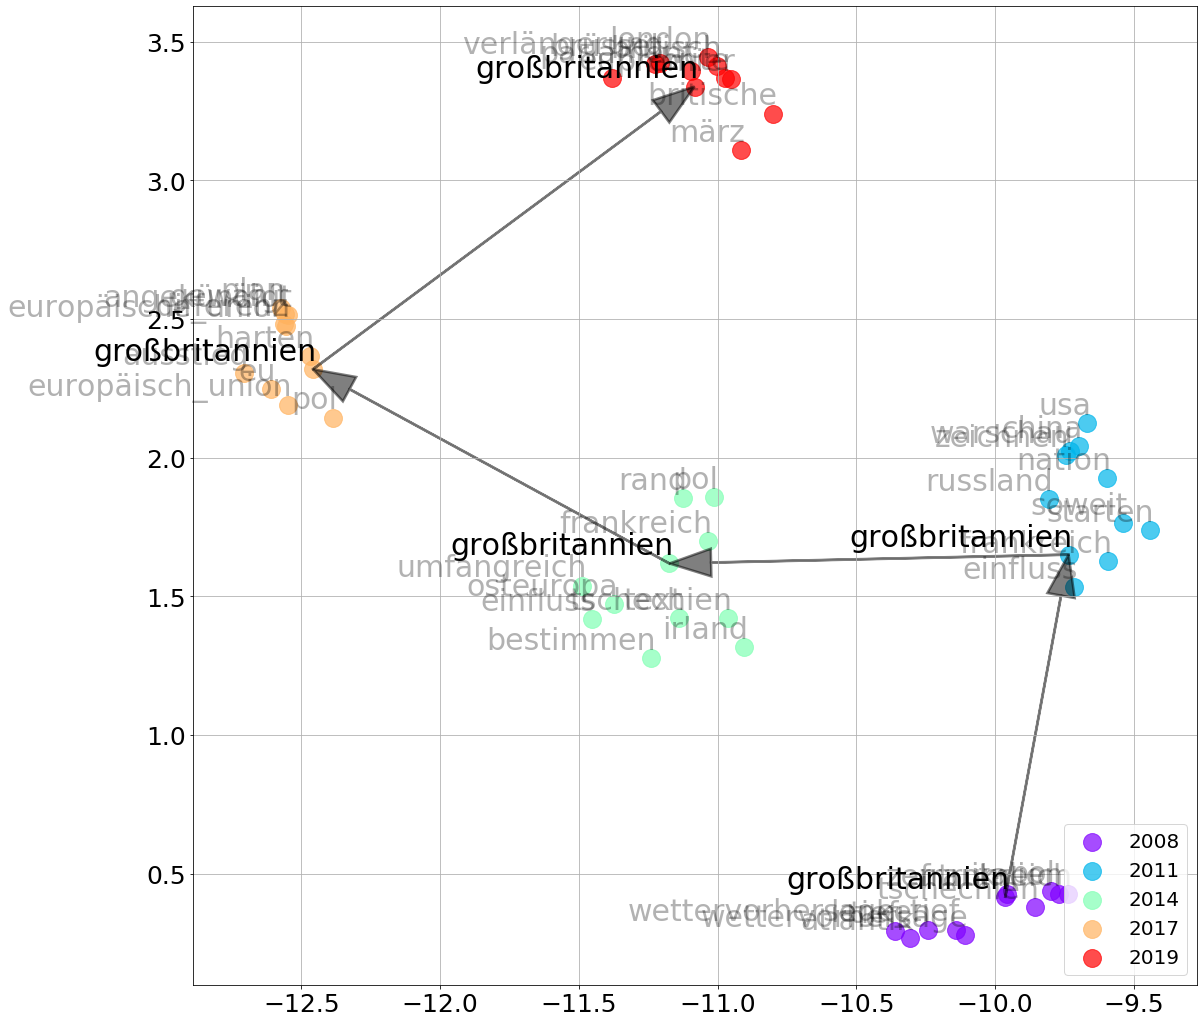

In [14]:
years = ["2008", "2011", "2014", "2017", "2019"]
x = [yearly_models[1], yearly_models[4], yearly_models[7],
     yearly_models[10], yearly_models[-2]]
tsne_plot(x, ["großbritannien"], years, 10, arrow_head_width=0.1)

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches

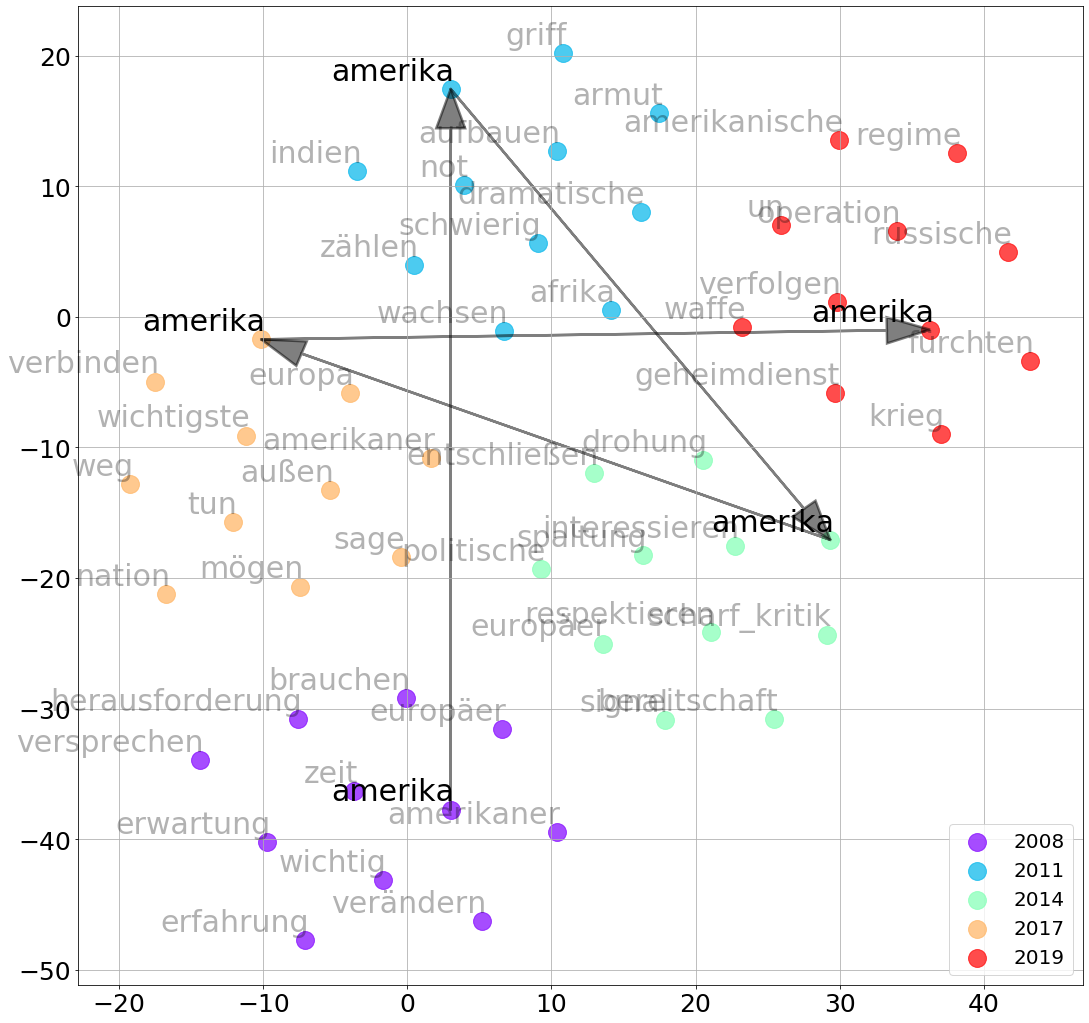

In [15]:
years = ["2008", "2011", "2014", "2017", "2019"]
x = [yearly_models[1], yearly_models[4], yearly_models[7],
     yearly_models[10], yearly_models[-2]]
tsne_plot(x, ["amerika"], years, 10, arrow_head_width=2)

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches

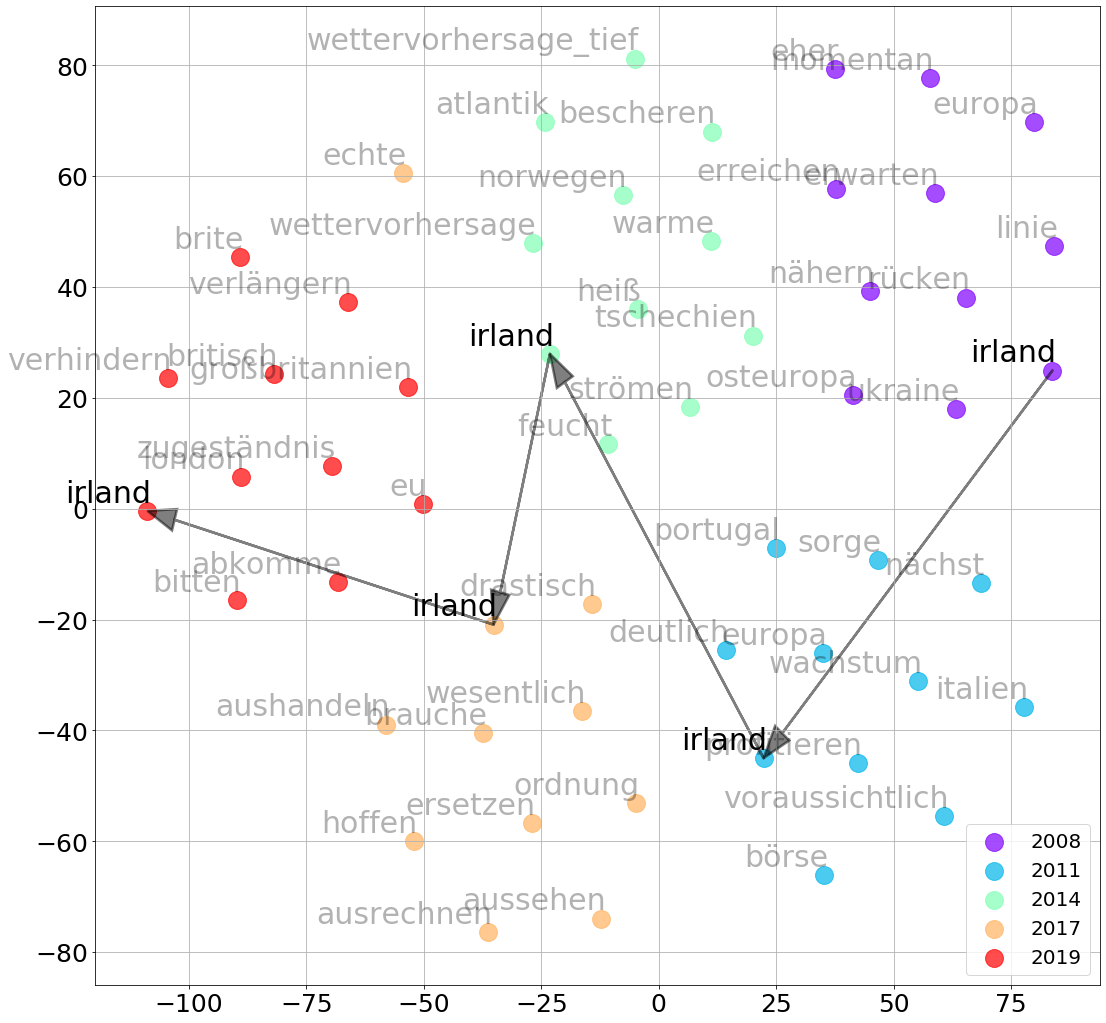

In [16]:
years = ["2008", "2011", "2014", "2017", "2019"]
x = [yearly_models[1], yearly_models[4], yearly_models[7],
     yearly_models[10], yearly_models[-2]]
tsne_plot(x, ["irland"], years, 10, arrow_head_width=4)

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches

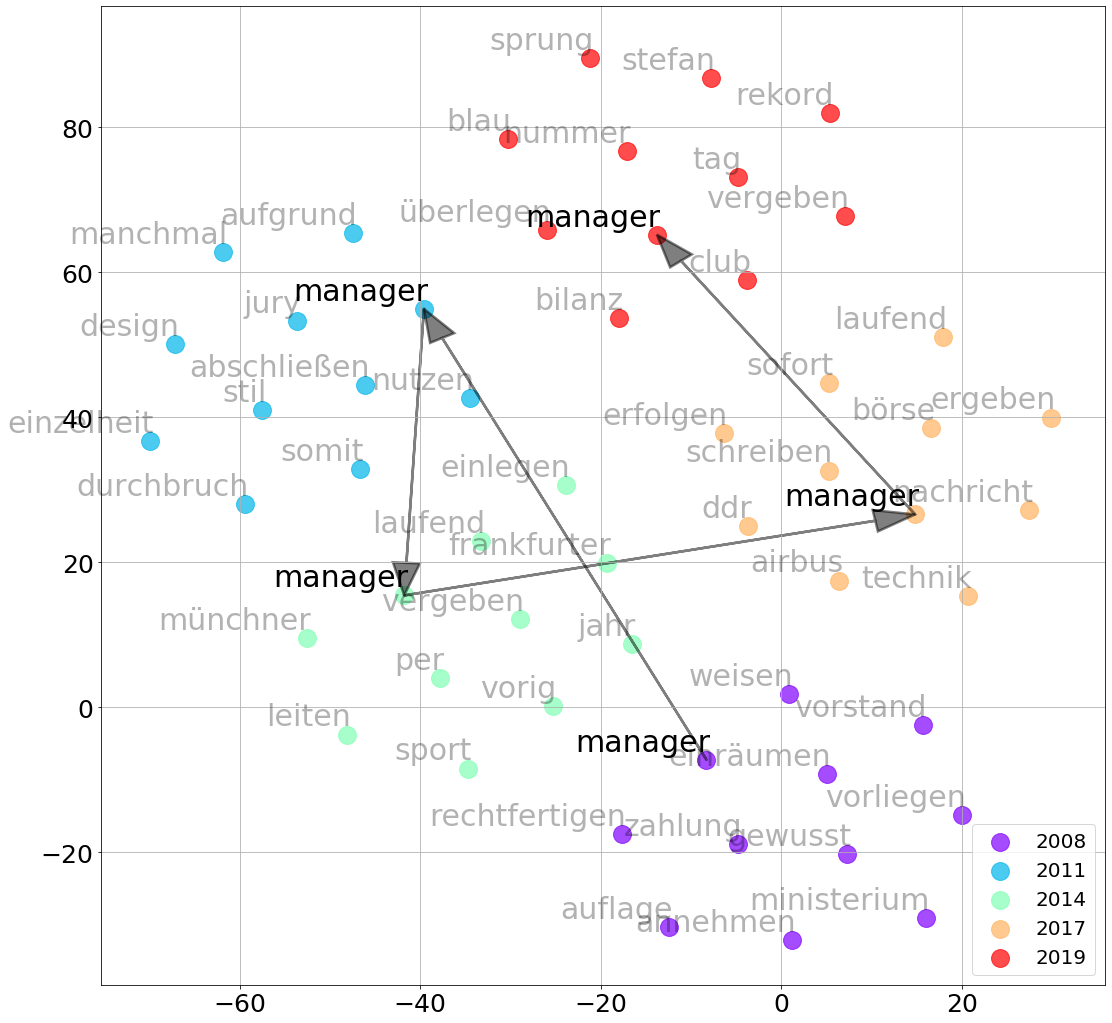

In [17]:
years = ["2008", "2011", "2014", "2017", "2019"]
x = [yearly_models[1], yearly_models[4], yearly_models[7],
     yearly_models[10], yearly_models[-2]]
tsne_plot(x, ["manager"], years, 10, arrow_head_width=3)

4.2 Four year models

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


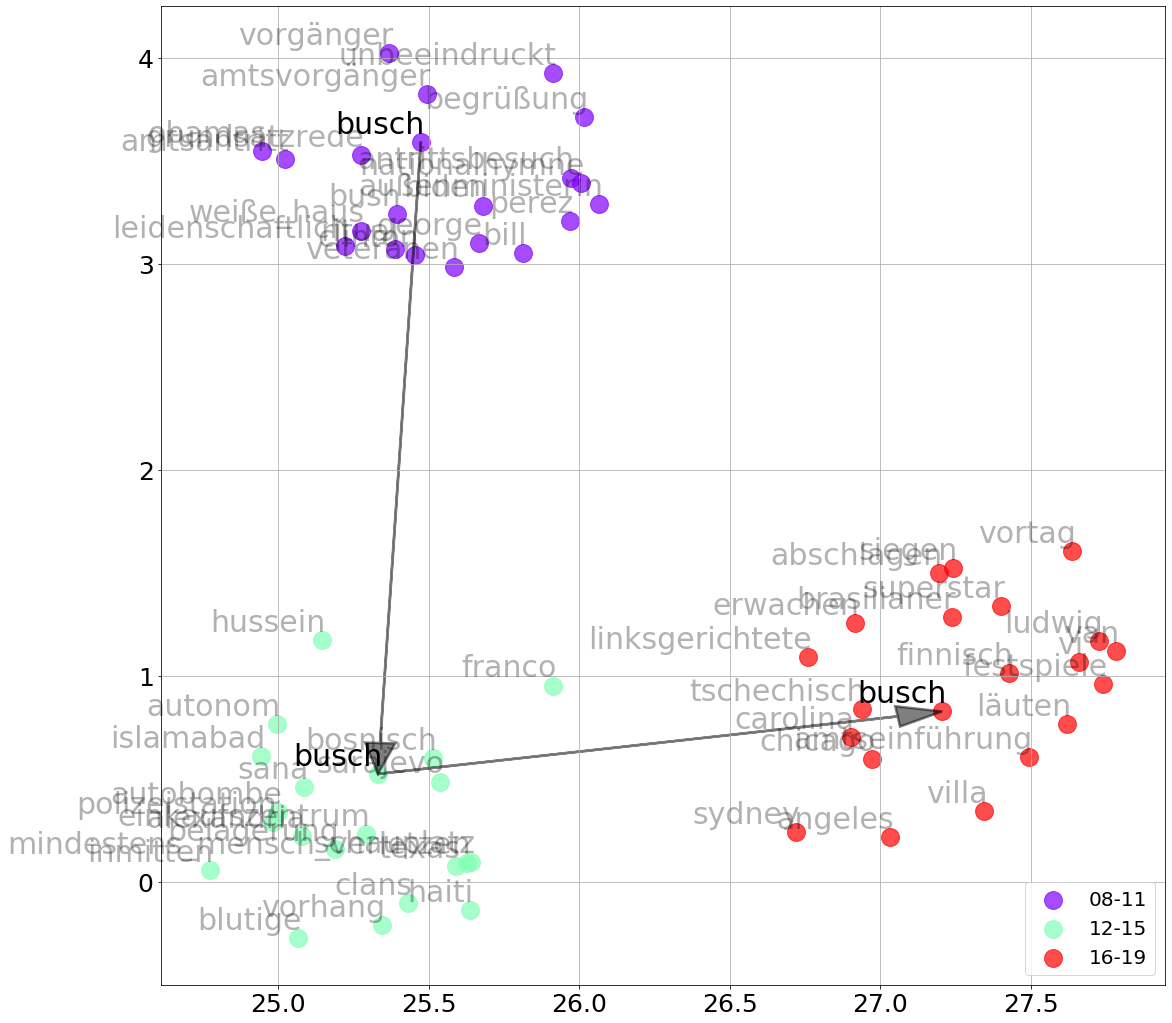

In [18]:
years = ["08-11", "12-15", "16-19"]
tsne_plot(models_four_years, ["busch"], years, 20, arrow_head_width=0.1)

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


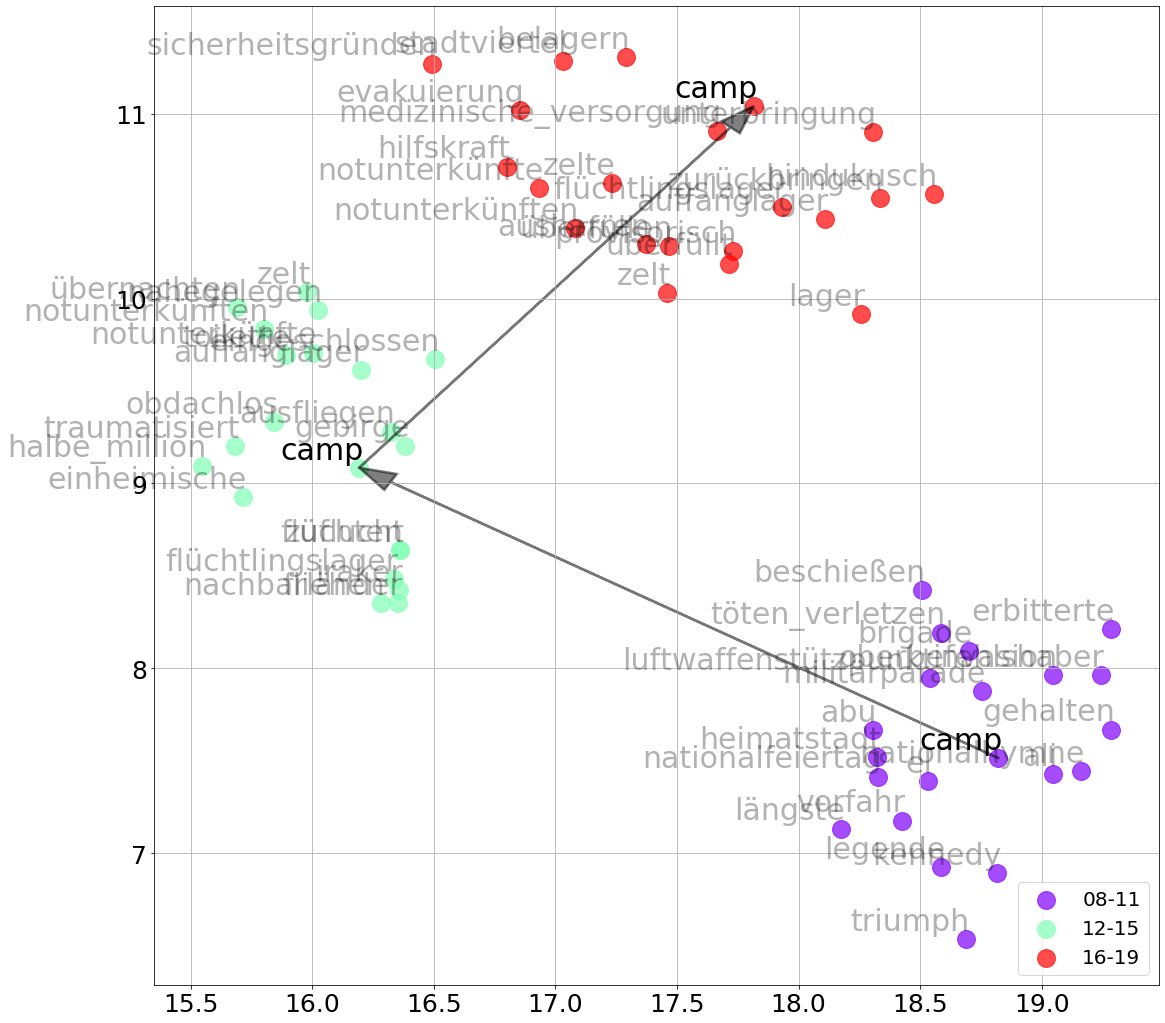

In [19]:
years = ["08-11", "12-15", "16-19"]
tsne_plot(models_four_years, ["camp"], years, 20, arrow_head_width=0.1)